# Analyzing 1.1 Million Bike Sharing Trips

> https://www.fordgobike.com/

**Ford GoBike is a [bike share system](https://en.wikipedia.org/wiki/Bicycle-sharing_system) operating in the Bay Area, with thousands of public bikes for use across San Francisco, East Bay and San Jose.**

**Ford periodically publishes data on users' trips [here](https://s3.amazonaws.com/fordgobike-data/index.html). Using that data, we'll attempt to get an idea of the scale of Ford GoBike's operation. We'll also try to get an idea of how different customer segments use the service.**

In [200]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from bokeh.plotting import figure, output_notebook, show # bokeh plotting library
# We'll show the plots in the cells of this notebook
output_notebook()

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

Loading BokehJS ...

In [201]:
%time

df = pd.read_csv('./2017-fordgobike-tripdata.csv')
df1 = pd.read_csv('201801-fordgobike-tripdata.csv')
df2 = pd.read_csv('201802-fordgobike-tripdata.csv')
df3 = pd.read_csv('201803-fordgobike-tripdata.csv')
df4 = pd.read_csv('201804-fordgobike-tripdata.csv')
df5 = pd.read_csv('201805-fordgobike-tripdata.csv')

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.1 µs


In [202]:
df = pd.concat([df, df1, df2, df3, df4, df5], sort=True)

In [203]:
# df.to_csv('./fordgobike.csv')

In [204]:
list(df)

['bike_id',
 'bike_share_for_all_trip',
 'duration_sec',
 'end_station_id',
 'end_station_latitude',
 'end_station_longitude',
 'end_station_name',
 'end_time',
 'member_birth_year',
 'member_gender',
 'start_station_id',
 'start_station_latitude',
 'start_station_longitude',
 'start_station_name',
 'start_time',
 'user_type']

In [205]:
df.shape

(1142896, 16)

We are only interesting in users whose genders are known.

In [207]:
df = df[df.member_gender.isin(['Male', 'Female'])]
df.head()

bike_id bike_share_for_all_trip  duration_sec  end_station_id  \
0        96                     NaN         80110              43   
1        88                     NaN         78800              96   
4      3167                     NaN         43603             247   
6      3539                     NaN          4507             259   
12     2311                     NaN          2183              24   

    end_station_latitude  end_station_longitude  \
0              37.778768            -122.415929   
1              37.766210            -122.426614   
4              37.867789            -122.265896   
6              37.866249            -122.299371   
12             37.789677            -122.390428   

                                     end_station_name  \
0   San Francisco Public Library (Grove St at Hyde...   
1                               Dolores St at 15th St   
4                           Fulton St at Bancroft Way   
6                             Addison St at Fourth St   
12                              Spear St at Folsom St   

                    end_time  member_birth_year member_gender  \
0   2018-01-01 15:12:50.2450             1987.0          Male   
1   2018-01-01 13:49:55.6170             1965.0        Female   
4   2018-01-01 02:29:57.5710             1997.0        Female   
6   2018-01-01 01:04:35.6190             1991.0        Female   
12  2018-01-01 00:29:18.7430             1990.0          Male   

    start_station_id  start_station_latitude  start_station_longitude  \
0                 74               37.776435              -122.426244   
1                284               37.784872              -122.400876   
4                239               37.868813              -122.258764   
6                259               37.866249              -122.299371   
12                67               37.776639              -122.395526   

                                   start_station_name  \
0                               Laguna St at Hayes St   
1   Yerba Buena Center for the Arts (Howard St at ...   
4                       Bancroft Way at Telegraph Ave   
6                             Addison St at Fourth St   
12  San Francisco Caltrain Station 2  (Townsend St...   

                  start_time   user_type  
0   2017-12-31 16:57:39.6540    Customer  
1   2017-12-31 15:56:34.8420    Customer  
4   2017-12-31 14:23:14.0010  Subscriber  
6   2017-12-31 23:49:28.4220    Customer  
12  2017-12-31 23:52:55.5810  Subscriber

Let's convert our time columns to datetime so we can operate on them using pandas datetime functions

In [208]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df = df.sort_values(by='start_time')

Let's get an idea of the spread of durations

In [209]:
df['duration_sec'].describe()

count    1.015767e+06
mean     7.863350e+02
std      2.229480e+03
min      6.100000e+01
25%      3.520000e+02
50%      5.430000e+02
75%      8.260000e+02
max      8.625200e+04
Name: duration_sec, dtype: float64

Let's add columns for distances and durations in hours for future use.

In [210]:
from math import sin, cos, sqrt, atan2, radians

def distance(p1, p2):
    """Takes points in [lon,lat] form and returns the distance in km between them."""
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(abs(p1[0]))
    lat1 = radians(abs(p1[1]))
    lon2 = radians(abs(p2[0]))
    lat2 = radians(abs(p2[1]))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [211]:
df['distance_km'] = df.apply(lambda i: distance([i['start_station_longitude'],i['start_station_latitude']],
                            [i['end_station_longitude'],i['end_station_latitude']]), axis=1)

In [212]:
df['duration_hr'] = df.duration_sec / 3600

## Mapping Trips

### Ford GoBike Stations

**A station is the row of bikes that can be found throughout the Bay Area. There are 550 stations across San Francisco, the East Bay and San Jose. They are solar powered, and each station consists of a variable number of bike docking ports.**

<img src='./stations-map.png' />
<br/>
<center><em>Ford GoBike Stations in the San Francisco Bay Area (Source: <a href="https://member.fordgobike.com/map/">website</a>)</em></center>

Let's find longitude and latitudes range for start and end locations

In [213]:
print(np.min(df['start_station_longitude']), np.min(df['start_station_latitude']))
print(np.max(df['start_station_longitude']), np.max(df['start_station_latitude']))

print(np.min(df['end_station_longitude']), np.min(df['end_station_latitude']))
print(np.max(df['end_station_longitude']), np.max(df['end_station_latitude']))

-122.444292605 37.3128540429
-121.8741186 37.8802224459
-122.444292605 37.3128540429
-121.8741186 37.8802224459


Let's define a base plot

In [214]:
BayArea = x_range, y_range = ((-122.44429260492323, -121.8741186), (37.3172979, 37.88022244590679))

plot_width = int(1000)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan, wheel_zoom, reset', plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, outline_line_color=None,
              min_border=0, min_border_left=0, min_border_right=0,
              min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='blue', size=5)

Here is a start locations scatter plot

In [215]:
import datashader as ds
from datashader import transfer_functions as tr_fns
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:2]

In [216]:
%%time
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'start_station_longitude', 'start_station_latitude')
img = tr_fns.shade(agg, cmap=["white", 'darkblue'], how='linear')

img

CPU times: user 31.9 ms, sys: 10.1 ms, total: 42 ms
Wall time: 43.8 ms


### Trip Origin Stations

**This gives us an idea of the usage rate of stations as trip origins. The points on the plots are colored from bright yellow to crimson based on the frequency of trips originating from the stations - bright yellow being the least frequent.**

In [217]:
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_start_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'start_station_longitude', 'start_station_latitude')
    img = tr_fns.shade(agg, cmap=Hot, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.5, max_px=4)

### Trip Destination Stations

**This gives us an idea of the usage rate of stations as trip destinations. The points on the plots are colored from bright yellow to crimson based on the frequency of trips ending at the stations - bright yellow being the least frequent.****

In [219]:
def create_end_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'end_station_longitude', 'end_station_latitude')
    img = tr_fns.shade(agg, cmap=Hot, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.5, max_px=4)

In [220]:
p = base_plot(title='End Stations by Frequency', background_fill_color=background)
# export(create_end_image(*BayArea), 'end_stations')
InteractiveImage(p, create_end_image)

### Longest Trips

Let's take a look at the trip with the longest duration.

In [221]:
df[df.duration_sec == max(df.duration_sec)]

bike_id bike_share_for_all_trip  duration_sec  end_station_id  \
120423     1214                     NaN         86252              18   

        end_station_latitude  end_station_longitude  \
120423             37.850222            -122.260172   

                     end_station_name                end_time  \
120423  Telegraph Ave at Alcatraz Ave 2017-11-19 12:14:05.244   

        member_birth_year member_gender  start_station_id  \
120423             1993.0        Female               245   

        start_station_latitude  start_station_longitude  \
120423               37.870348              -122.267764   

            start_station_name              start_time user_type  distance_km  \
120423  Downtown Berkeley BART 2017-11-18 12:16:33.230  Customer     2.335747   

        duration_hr  
120423    23.958889

**The trip with the longest duration is a 2.3km trip that took 24 hours supposedly. This might be due to a booking error or a customer mistake.**

Let's take a look at the trip with the longest distance.

In [266]:
df[df.distance_km == max(df.distance_km)]

bike_id bike_share_for_all_trip  duration_sec  end_station_id  \
7900      319                      No         21836             303   

      end_station_latitude  end_station_longitude            end_station_name  \
7900             37.352601            -121.905733  San Pedro St at Hedding St   

                    end_time  member_birth_year member_gender  \
7900 2018-03-29 20:29:44.284             1974.0        Female   

      start_station_id  start_station_latitude  start_station_longitude  \
7900                16                37.79413               -122.39443   

           start_station_name              start_time user_type  distance_km  \
7900  Steuart St at Market St 2018-03-29 14:25:47.670  Customer    65.329756   

      duration_hr   month      speed  
7900     6.065556 2018-03  10.770614

**The trip with the longest distance is by a female user who took a 65km trip that lasted 6 hours from Steuart St to San Pedro St. Let's map the two locations:**

In [223]:
locs = df[df.distance_km == max(df.distance_km)]
lon1 = locs.iloc[0, :]['start_station_longitude']
lat1 = locs.iloc[0, :]['start_station_latitude']
lon2 = locs.iloc[0, :]['end_station_longitude']
lat2 = locs.iloc[0, :]['end_station_latitude']

df_longest = pd.DataFrame(data={'start_station_longitude': [lon1, lon2], 'start_station_latitude': [lat1, lat2]})

def create_longest_trip_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df_longest, 'start_station_longitude', 'start_station_latitude')
    img = tr_fns.shade(agg, cmap=inferno, how='eq_hist')
    return tr_fns.dynspread(img, threshold=0.5, max_px=4)

In [224]:
p = base_plot(title="Longest trip: from Steuart St to San Pedro St", background_fill_color=background)
# export(create_image(*BayArea), "BayArea_end_locs")
InteractiveImage(p, create_longest_trip_image)

**She appears to have journeyed from one end of the Bay to the other.**

### Trip Paths

**Using [kepler.gl](https://github.com/uber/kepler.gl), we are able to get a visual of the density of trips taken between the different areas and within them. There aren't a lot of trips going from San Francisco or the East Bay to San Jose. Trips between San Francisco and the East Bay are more frequent. While trips within each area occur most frequently.**

<img src='./start_to_end.png' />
<br/>
<center><em>Trips from start to end stations</em></center>

### Station Usage Based on Trip Duration

**Let's get an idea of how often stations are used for trips based on the trip durations. The heights of the points shown above the surface reflect the durations of trips taken from stations on the ground (from which the hovering points are emanating). Trips in San Francisco take the longest, then the East Bay, and lastly San Jose.**

<img src='./stations_by_duration.png' />
<br/>
<center><em>Trips by Duration</em></center>

## Behaviours of Customer Segments

### User Types

**Subscribers** are cyclers who are subscribed to some plan, while **customers** are cyclers who embark on single rides. See https://www.fordgobike.com/pricing for more details.

### Trip durations based on gender

**\*This next cell should be included in the poster:\***

In [206]:
df.member_gender.value_counts()

Male      774554
Female    241213
Other      14759
Name: member_gender, dtype: int64

In [250]:
df['month'] = df.start_time.dt.to_period('M')

[None]

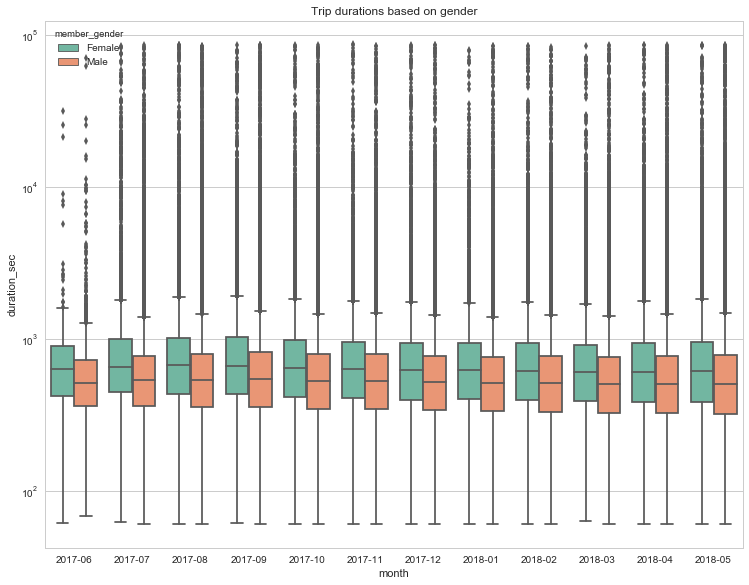

In [251]:
sns.set_style('whitegrid')
ax = sns.boxplot(x='month', y='duration_sec', palette='Set2', hue='member_gender', data=df)
ax.set_title('Trip durations based on gender')
ax.set(yscale='log')

**Women's trips tend to take longer on average than men's. Let's see whether the speeds of each gender can tell us more.**

### Trip speeds based on gender

Let's create a column of speed in kilometers per hour

In [252]:
df['speed'] = df.distance_km / df.duration_hr

Text(0.5,1,'Trip speeds based on gender')

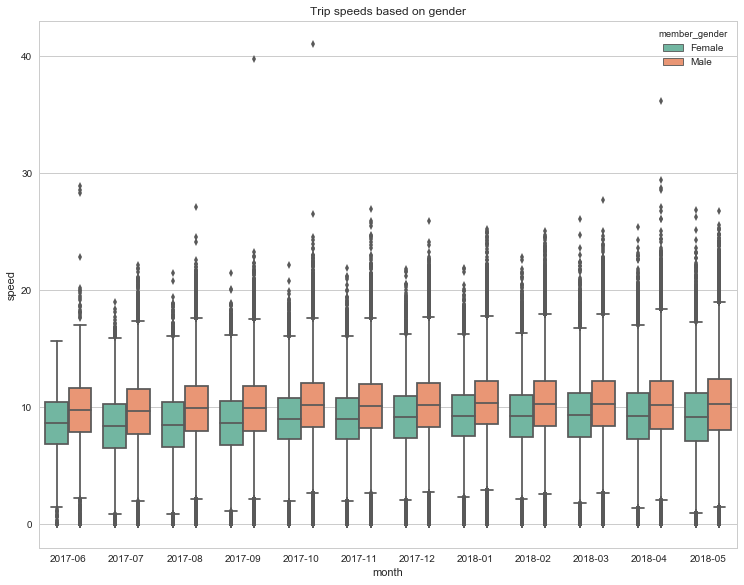

In [253]:
ax = sns.boxplot(x='month', y='speed', palette='Set2', hue='member_gender', data=df)
ax.set_title('Trip speeds based on gender')

Text(0.5,1,'Trip speeds based on gender distinguished by user type')

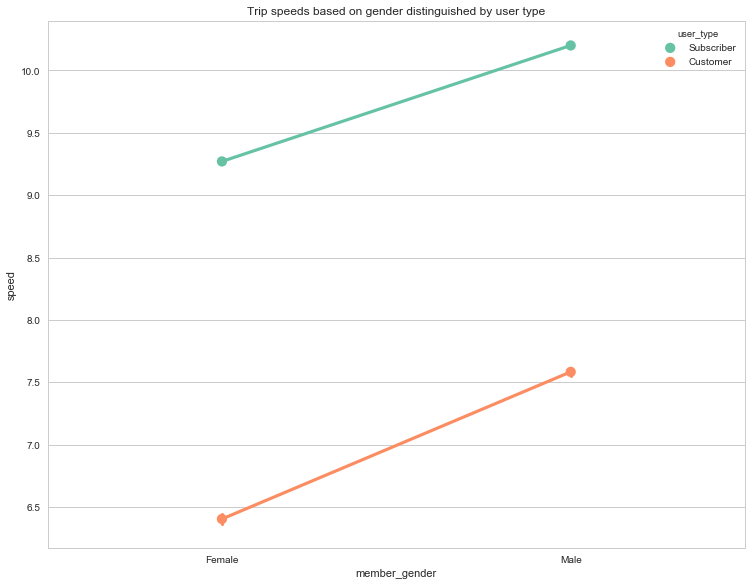

In [254]:
ax = sns.pointplot(x='member_gender', y='speed', palette='Set2', hue='user_type', data=df);
ax.set_title('Trip speeds based on gender distinguished by user type')

**From the plots above, we can see that men cycle faster on average than women. This might explain why women's trips take longer. However, it could simply be that women take longer trips, and therefore tend to be slower, since it's difficult to maintain relatively high speeds over long distances. We can plot the distances ridden by both genders to gain more insight.**

Text(0.5,1,'Trip distances based gender')

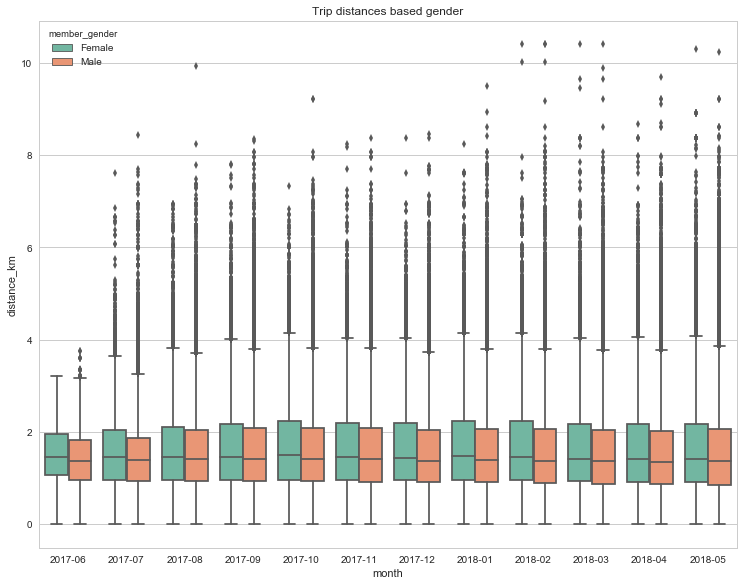

In [264]:
# Let's assume that trips spanning more than 10km are outliers.
df_tmp = df[df['distance_km'] < 11]
ax = sns.boxplot(x='month', y='distance_km', palette='Set2', hue='member_gender', data=df_tmp)
ax.set_title('Trip distances based gender')

**It appears that women tend to cycle for longer distances than men, and this may very well explain the difference between their average speeds.**

### Trip durations based on user type

[None]

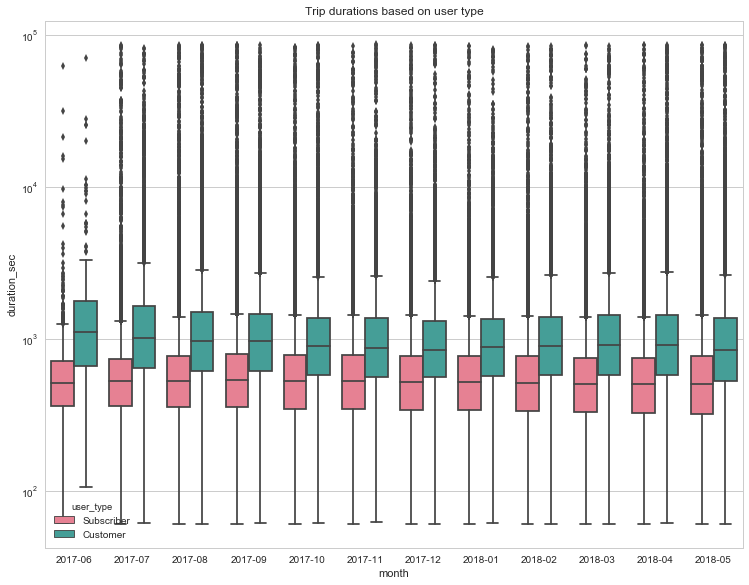

In [257]:
ax = sns.boxplot(x='month', y='duration_sec', palette='husl', hue='user_type', data=df)
ax.set_title('Trip durations based on user type')
ax.set(yscale='log')

**Customers appear to travel longer distances than subscribers. Let's see what their speeds can tell us.**

### Trip speeds based on user type

Text(0.5,1,'Trip speeds based on user type distinguished by gender')

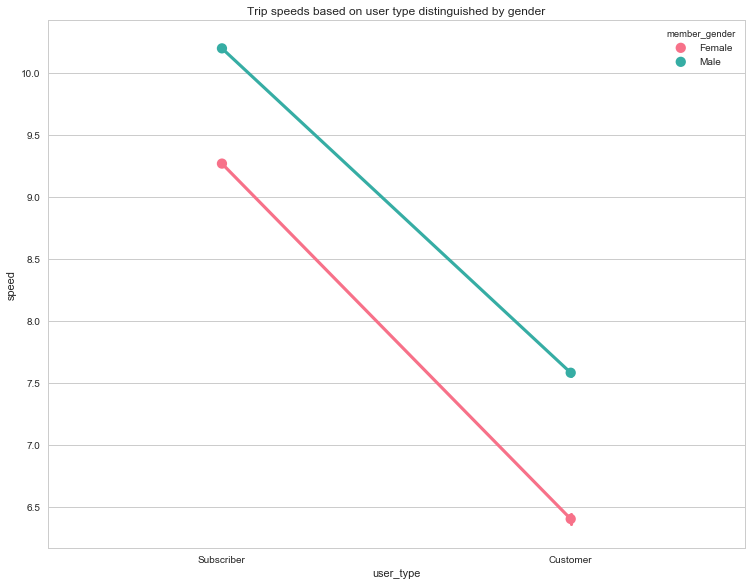

In [256]:
ax = sns.pointplot(x="user_type", y="speed", palette='husl', hue="member_gender", data=df)
ax.set_title('Trip speeds based on user type distinguished by gender')

Text(0.5,1,'Trip speeds based on user type')

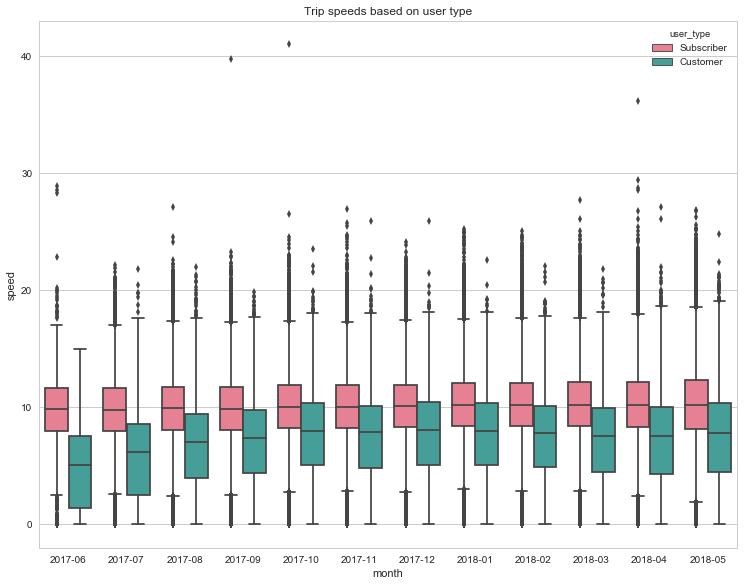

In [255]:
ax = sns.boxplot(x='month', y='speed', palette='husl', hue='user_type', data=df)
ax.set_title('Trip speeds based on user type')

**Similar to what we had with the genders, subscribers cycle faster on average than customers. We could again either conclude that customers simply cycle slower, or that customers are slower because they travel longer distances on average. We can again plot the distances ridden by each group to get a better picture.**

Text(0.5,1,'Trip distances based user type')

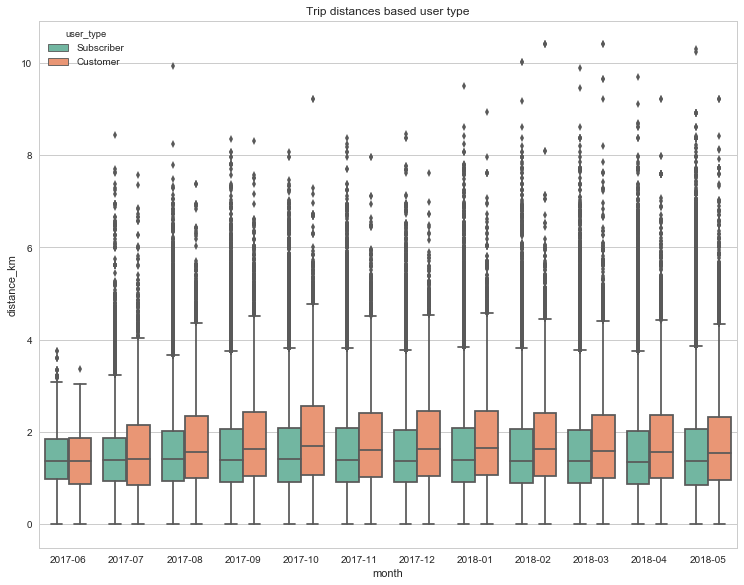

In [265]:
# Let's assume that trips spanning more than 10km are outliers.
df_tmp = df[df['distance_km'] < 11]
ax = sns.boxplot(x='month', y='distance_km', palette='Set2', hue='user_type', data=df_tmp)
ax.set_title('Trip distances based user type')

**Similar to the case of the genders, it also appears here that customers tend to bike for londer distances than men. This might explain the differences in their speeds.**

## Conclusion

**Mapping trips gave a good idea of how the Ford GoBike service is used across the Bay and within its operating areas. It also gave an idea of the different usage levels of docking stations, and one can dig deeper in order to pursue optimizations for the service.**

**The customer segments based on gender and pricing tier; and their behaviours could provide supplementary insight to assist with targetting and pricing focus. There are of course assumptions that need to be accounted for - e.g. male customers outnumber female customers 3 to 1, and it wasn't factored into the analysis.**

**The hope is that some basic insights into the Ford GoBike bike sharing service and its users in the Bay Area has been gained.**